# Comparative Analysis of Four Text-to-SQL Solutions

This analysis compares four different approaches to Text-to-SQL:
1. **Snowflake Cortex Analyst** - Snowflake's managed service
2. **LangChain DB Agent** - Agentic approach with LangChain
3. **Vanilla Text2SQL** - Direct LLM-based conversion
4. **Agentar-Scale-SQL** - Advanced agentic SQL generation with scaling capabilities

## Analysis Overview
- Dataset: 64 SQL generation questions with varying difficulty levels
- Evaluation metrics: SQL precision, Result accuracy, Execution time
- Difficulty levels: Simple (43), Moderate (17), Challenging (4)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

result_csv_file = "evaluation_results/comparison_20251013_144531.csv"

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Load the detailed comparison data
df = pd.read_csv(result_csv_file)

# Display basic info
print(f"Total questions analyzed: {len(df)}")
print(f"\nDifficulty distribution:")
print(df['difficulty'].value_counts().sort_index())
print(f"\nColumns in dataset: {df.columns.tolist()}")

Total questions analyzed: 64

Difficulty distribution:
difficulty
challenging     4
moderate       17
simple         43
Name: count, dtype: int64

Columns in dataset: ['question_id', 'question', 'evidence', 'difficulty', 'expected_sql', 'expected_result', 'Cortex_Analyst_sql', 'Cortex_Analyst_result', 'Cortex_Analyst_match', 'Cortex_Analyst_error', 'Cortex_Analyst_sql_exec_error', 'LangChain_Agent_sql', 'LangChain_Agent_result', 'LangChain_Agent_match', 'LangChain_Agent_error', 'LangChain_Agent_sql_exec_error', 'Vanilla_Text2SQL_sql', 'Vanilla_Text2SQL_result', 'Vanilla_Text2SQL_match', 'Vanilla_Text2SQL_error', 'Agentar_Scale_SQL_sql', 'Agentar_Scale_SQL_result', 'Agentar_Scale_SQL_match', 'Agentar_Scale_SQL_error', 'Agentar_Scale_SQL_sql_exec_error']


## 1. Overall Performance Comparison

         Solution  Total Questions  Correct Results  Accuracy (%)
   Cortex Analyst               64               30        46.875
  LangChain Agent               64               26        40.625
 Vanilla Text2SQL               64               30        46.875
Agentar-Scale-SQL               64               40        62.500


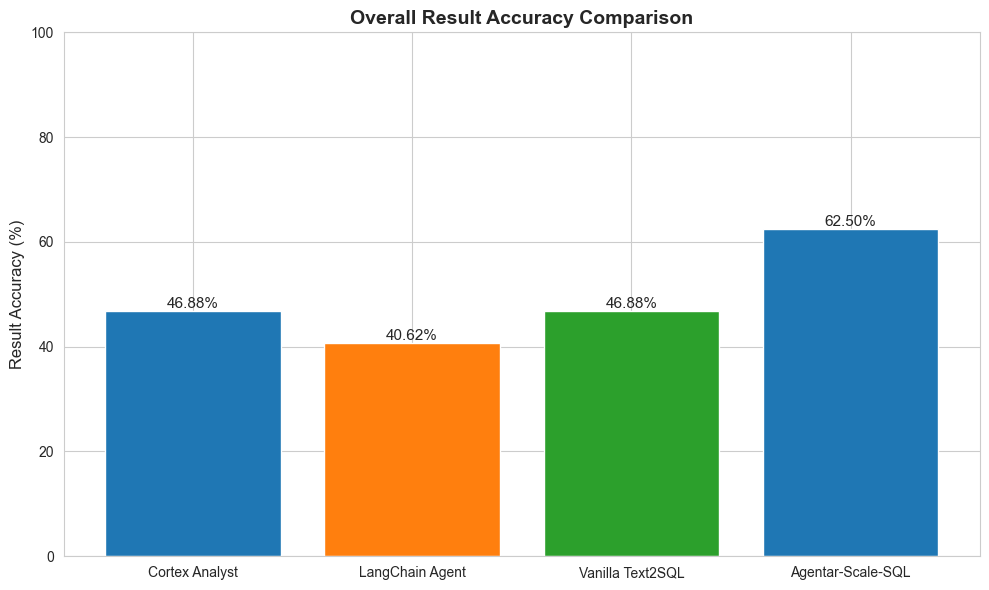

In [2]:
# Calculate overall metrics for each solution
solutions = {
    'Cortex Analyst': 'Cortex_Analyst',
    'LangChain Agent': 'LangChain_Agent',
    'Vanilla Text2SQL': 'Vanilla_Text2SQL',
    'Agentar-Scale-SQL': 'Agentar_Scale_SQL'
}

results_summary = []
for name, prefix in solutions.items():
    match_col = f'{prefix}_match'
    total = len(df)
    matches = df[match_col].str.upper().eq('YES').sum()
    accuracy = (matches / total) * 100
    
    results_summary.append({
        'Solution': name,
        'Total Questions': total,
        'Correct Results': matches,
        'Accuracy (%)': accuracy
    })

results_df = pd.DataFrame(results_summary)
print(results_df.to_string(index=False))

# Visualize overall accuracy
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(results_df['Solution'], results_df['Accuracy (%)'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Result Accuracy (%)', fontsize=12)
ax.set_title('Overall Result Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 100])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

## 2. Performance by Difficulty Level


Accuracy by Difficulty Level (%):
Solution     Agentar-Scale-SQL  Cortex Analyst  LangChain Agent  Vanilla Text2SQL
Difficulty                                                                       
Challenging          50.000000       25.000000        25.000000         50.000000
Moderate             52.941176       41.176471        35.294118         35.294118
Simple               67.441860       51.162791        44.186047         51.162791


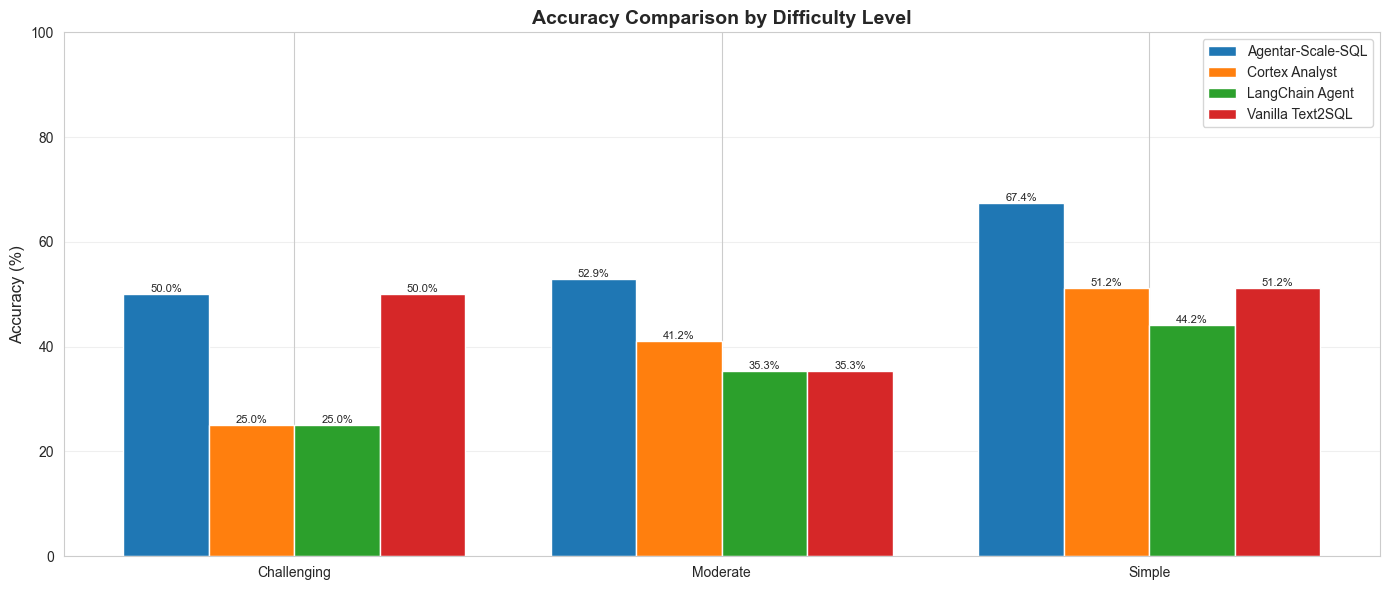

In [3]:
# Performance breakdown by difficulty
difficulty_analysis = []

for difficulty in ['simple', 'moderate', 'challenging']:
    subset = df[df['difficulty'] == difficulty]
    total = len(subset)
    
    for name, prefix in solutions.items():
        match_col = f'{prefix}_match'
        matches = subset[match_col].str.upper().eq('YES').sum()
        accuracy = (matches / total) * 100 if total > 0 else 0
        
        difficulty_analysis.append({
            'Difficulty': difficulty.capitalize(),
            'Solution': name,
            'Total': total,
            'Correct': matches,
            'Accuracy (%)': accuracy
        })

difficulty_df = pd.DataFrame(difficulty_analysis)
pivot_df = difficulty_df.pivot(index='Difficulty', columns='Solution', values='Accuracy (%)')

print("\nAccuracy by Difficulty Level (%):")
print(pivot_df.to_string())

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(pivot_df.index))
width = 0.2

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i, (col, color) in enumerate(zip(pivot_df.columns, colors)):
    offset = width * (i - 1.5)
    bars = ax.bar(x + offset, pivot_df[col], width, label=col, color=color)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=8)

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Accuracy Comparison by Difficulty Level', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pivot_df.index)
ax.legend(fontsize=10, loc='upper right')
ax.set_ylim([0, 100])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Agreement and Disagreement Analysis


Agreement/Disagreement Analysis:
  Agreement Pattern  Count
      All 4 Correct     18
        All 4 Wrong     17
        Only Cortex      2
     Only LangChain      3
       Only Vanilla      1
 Only Agentar-Scale      7
Mixed (2-3 Correct)     29


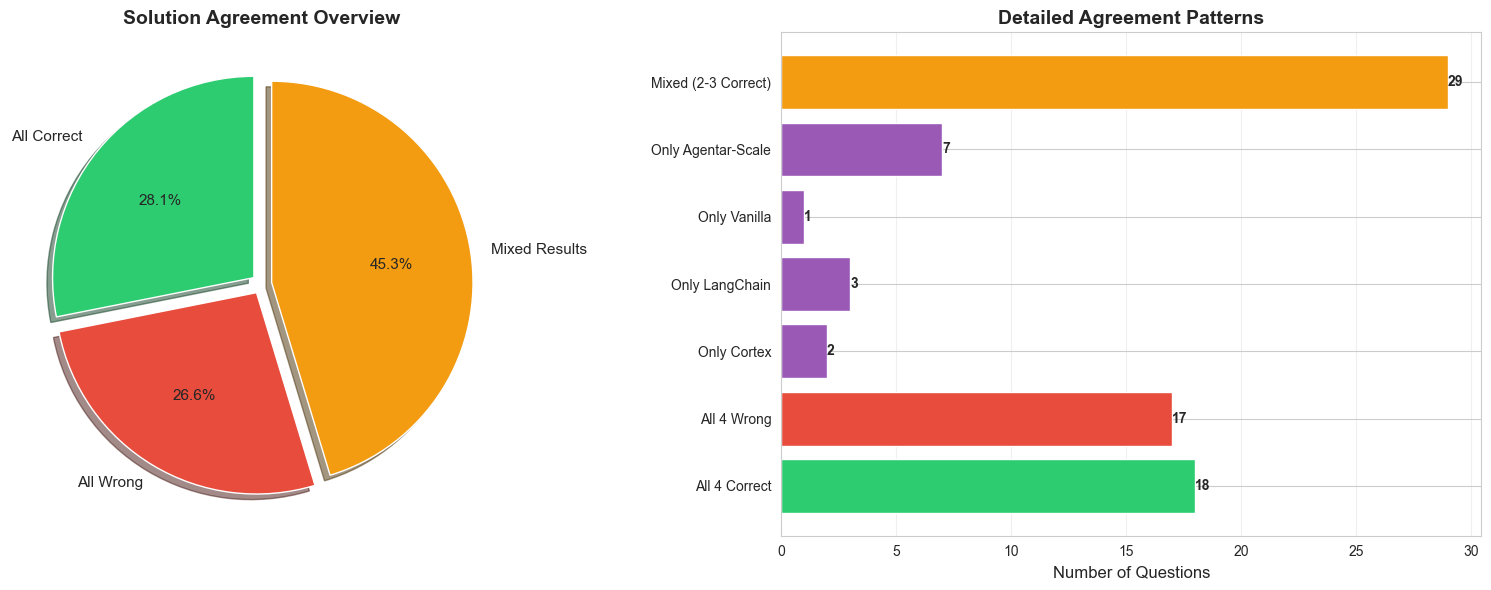

In [4]:
# Analyze agreement between solutions
df['cortex_correct'] = df['Cortex_Analyst_match'].str.upper() == 'YES'
df['langchain_correct'] = df['LangChain_Agent_match'].str.upper() == 'YES'
df['vanilla_correct'] = df['Vanilla_Text2SQL_match'].str.upper() == 'YES'
df['agentar_correct'] = df['Agentar_Scale_SQL_match'].str.upper() == 'YES'

# All agree
all_correct = (df['cortex_correct'] & df['langchain_correct'] & df['vanilla_correct'] & df['agentar_correct']).sum()
all_wrong = (~df['cortex_correct'] & ~df['langchain_correct'] & ~df['vanilla_correct'] & ~df['agentar_correct']).sum()

# Unique wins (only one solution got it right)
cortex_only = (df['cortex_correct'] & ~df['langchain_correct'] & ~df['vanilla_correct'] & ~df['agentar_correct']).sum()
langchain_only = (~df['cortex_correct'] & df['langchain_correct'] & ~df['vanilla_correct'] & ~df['agentar_correct']).sum()
vanilla_only = (~df['cortex_correct'] & ~df['langchain_correct'] & df['vanilla_correct'] & ~df['agentar_correct']).sum()
agentar_only = (~df['cortex_correct'] & ~df['langchain_correct'] & ~df['vanilla_correct'] & df['agentar_correct']).sum()

# Count mixed results
mixed_results = len(df) - all_correct - all_wrong

agreement_data = {
    'Agreement Pattern': [
        'All 4 Correct', 
        'All 4 Wrong',
        'Only Cortex', 
        'Only LangChain', 
        'Only Vanilla',
        'Only Agentar-Scale',
        'Mixed (2-3 Correct)'
    ],
    'Count': [
        all_correct, 
        all_wrong,
        cortex_only, 
        langchain_only, 
        vanilla_only,
        agentar_only,
        mixed_results
    ]
}

agreement_df = pd.DataFrame(agreement_data)
print("\nAgreement/Disagreement Analysis:")
print(agreement_df.to_string(index=False))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart for overall agreement
labels_pie = ['All Correct', 'All Wrong', 'Mixed Results']
sizes_pie = [all_correct, all_wrong, mixed_results]
colors_pie = ['#2ecc71', '#e74c3c', '#f39c12']
explode_pie = (0.05, 0.05, 0.05)

ax1.pie(sizes_pie, explode=explode_pie, labels=labels_pie, colors=colors_pie,
        autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 11})
ax1.set_title('Solution Agreement Overview', fontsize=14, fontweight='bold')

# Bar chart for detailed breakdown
colors_bar = ['#2ecc71', '#e74c3c', '#9b59b6', '#9b59b6', '#9b59b6', '#9b59b6', '#f39c12']
bars = ax2.barh(agreement_df['Agreement Pattern'], agreement_df['Count'], color=colors_bar)
ax2.set_xlabel('Number of Questions', fontsize=12)
ax2.set_title('Detailed Agreement Patterns', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
             f'{int(width)}',
             ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Error Analysis

In [5]:
# Analyze questions where all solutions failed
all_failed = df[~df['cortex_correct'] & ~df['langchain_correct'] & ~df['vanilla_correct'] & ~df['agentar_correct']]

print(f"\n{len(all_failed)} questions where ALL solutions failed:")
print("=" * 80)
for idx, row in all_failed.iterrows():
    print(f"\nQuestion {row['question_id']} ({row['difficulty']}):")
    print(f"Q: {row['question'][:120]}...")
    if pd.notna(row['evidence']):
        print(f"Evidence: {row['evidence'][:100]}...")

# Analyze unique failures
cortex_failures = df[~df['cortex_correct'] & (df['langchain_correct'] | df['vanilla_correct'] | df['agentar_correct'])]
langchain_failures = df[~df['langchain_correct'] & (df['cortex_correct'] | df['vanilla_correct'] | df['agentar_correct'])]
vanilla_failures = df[~df['vanilla_correct'] & (df['cortex_correct'] | df['langchain_correct'] | df['agentar_correct'])]
agentar_failures = df[~df['agentar_correct'] & (df['cortex_correct'] | df['langchain_correct'] | df['vanilla_correct'])]

print(f"\n\nUnique Failure Analysis:")
print(f"Questions only Cortex Analyst failed: {len(cortex_failures)}")
print(f"Questions only LangChain Agent failed: {len(langchain_failures)}")
print(f"Questions only Vanilla Text2SQL failed: {len(vanilla_failures)}")
print(f"Questions only Agentar-Scale-SQL failed: {len(agentar_failures)}")


17 questions where ALL solutions failed:

Question 1474 (moderate):
Q: Which customers, paying in CZK, consumed the most gas in 2011?...
Evidence: Year 2011 can be presented as Between 201101 And 201112, which means between January and December in...

Question 1477 (simple):
Q: Which year recorded the most gas use paid in EUR?...

Question 1480 (moderate):
Q: What was the gas consumption peak month for SME customers in 2013?...
Evidence: Year 2013 can be presented as Between 201301 And 201312; The first 4 strings of the Date values in t...

Question 1481 (challenging):
Q: What is the difference in the annual average consumption of the customers with the least amount of consumption paid in C...
Evidence: annual average consumption of customer with the lowest consumption in each segment = total consumpti...

Question 1482 (challenging):
Q: Which of the three segments—SME, LAM and KAM—has the biggest and lowest percentage increases in consumption paid in EUR ...
Evidence: Increase or Dec

## 5. Success Pattern Analysis

Questions solved by at least one solution: 47 (73.4%)
Questions solved by at least two solutions: 34 (53.1%)


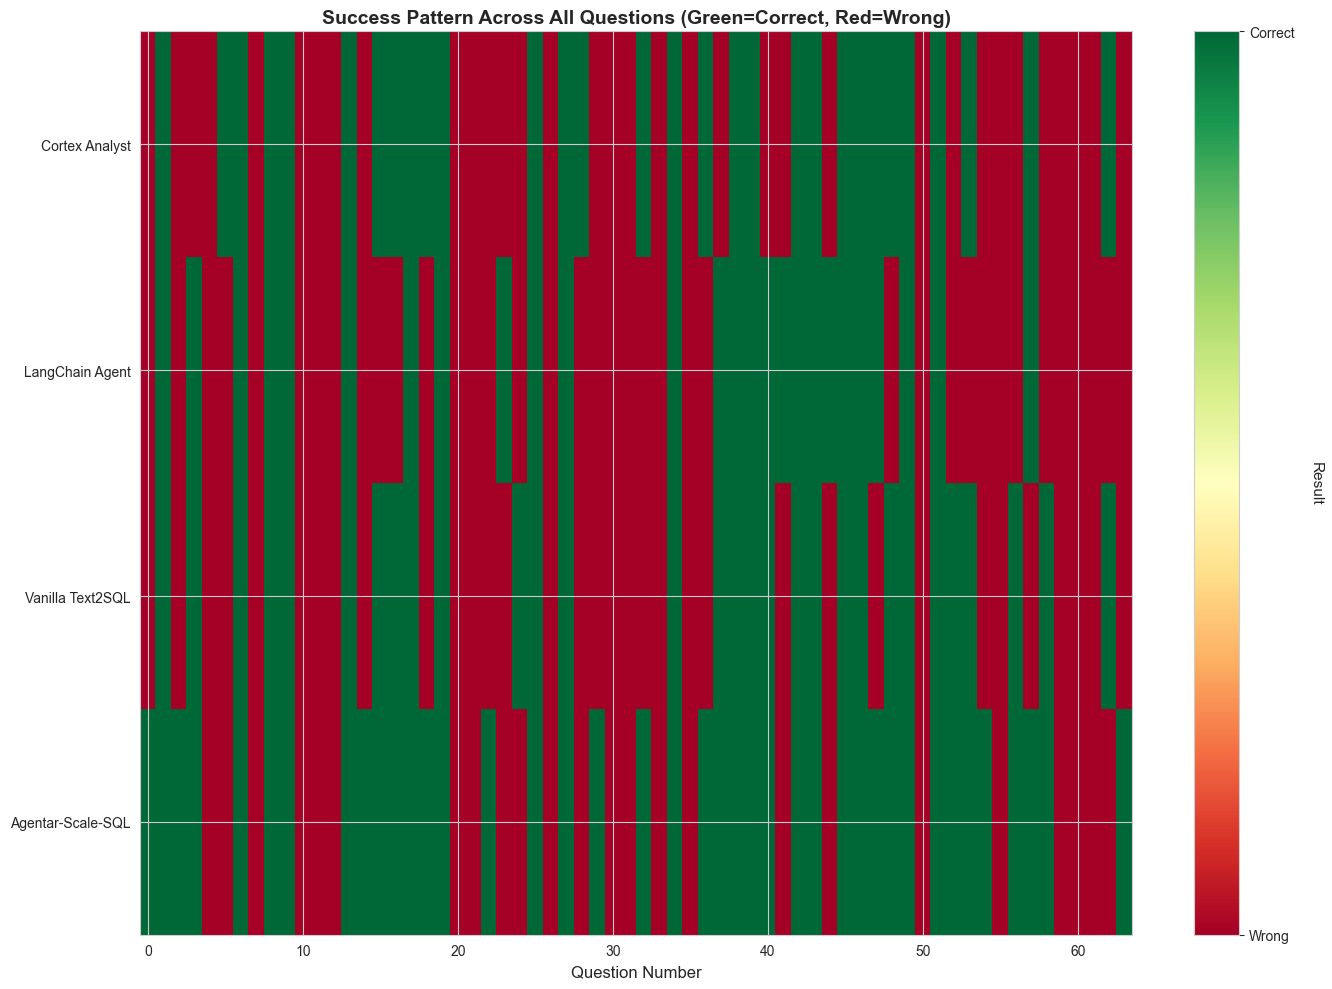

In [6]:
# Questions solved by at least one solution
at_least_one = df[df['cortex_correct'] | df['langchain_correct'] | df['vanilla_correct'] | df['agentar_correct']]
print(f"Questions solved by at least one solution: {len(at_least_one)} ({len(at_least_one)/len(df)*100:.1f}%)")

# Questions solved by at least two solutions  
at_least_two = df[(df['cortex_correct'].astype(int) + df['langchain_correct'].astype(int) + df['vanilla_correct'].astype(int) + df['agentar_correct'].astype(int)) >= 2]
print(f"Questions solved by at least two solutions: {len(at_least_two)} ({len(at_least_two)/len(df)*100:.1f}%)")

# Create a success matrix visualization
success_matrix = []
for idx, row in df.iterrows():
    success_matrix.append([
        1 if row['cortex_correct'] else 0,
        1 if row['langchain_correct'] else 0,
        1 if row['vanilla_correct'] else 0,
        1 if row['agentar_correct'] else 0
    ])

success_array = np.array(success_matrix)

fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(success_array.T, cmap='RdYlGn', aspect='auto', interpolation='nearest')

ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(['Cortex Analyst', 'LangChain Agent', 'Vanilla Text2SQL', 'Agentar-Scale-SQL'])
ax.set_xlabel('Question Number', fontsize=12)
ax.set_title('Success Pattern Across All Questions (Green=Correct, Red=Wrong)', 
             fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.set_label('Result', rotation=270, labelpad=20, fontsize=11)
cbar.ax.set_yticklabels(['Wrong', 'Correct'])

plt.tight_layout()
plt.show()

## 6. Key Findings and Insights

In [7]:
# Generate comprehensive insights
insights = []

# 1. Best performer
best_solution = results_df.loc[results_df['Accuracy (%)'].idxmax(), 'Solution']
best_accuracy = results_df['Accuracy (%)'].max()
insights.append(f"🏆 **Best Overall Performance**: {best_solution} with {best_accuracy:.2f}% accuracy")

# 2. Performance on difficult questions
challenging_subset = df[df['difficulty'] == 'challenging']
challenging_scores = {}
for name, prefix in solutions.items():
    matches = challenging_subset[f'{prefix}_match'].str.upper().eq('YES').sum()
    challenging_scores[name] = matches

best_challenging = max(challenging_scores, key=challenging_scores.get)
insights.append(f"💪 **Best on Challenging Questions**: {best_challenging} ({challenging_scores[best_challenging]}/{len(challenging_subset)} correct)")

# 3. Consistency
std_devs = {}
for name, prefix in solutions.items():
    diff_scores = []
    for diff in ['simple', 'moderate', 'challenging']:
        subset = df[df['difficulty'] == diff]
        if len(subset) > 0:
            acc = subset[f'{prefix}_match'].str.upper().eq('YES').sum() / len(subset) * 100
            diff_scores.append(acc)
    std_devs[name] = np.std(diff_scores)

most_consistent = min(std_devs, key=std_devs.get)
insights.append(f"📊 **Most Consistent Across Difficulty Levels**: {most_consistent} (std dev: {std_devs[most_consistent]:.2f}%)")

# 4. Unique strengths
insights.append(f"🎯 **Unique Correct Answers**:")
insights.append(f"   - Cortex Analyst only: {cortex_only} questions")
insights.append(f"   - LangChain Agent only: {langchain_only} questions")
insights.append(f"   - Vanilla Text2SQL only: {vanilla_only} questions")
insights.append(f"   - Agentar-Scale-SQL only: {agentar_only} questions")

# 5. Agreement
insights.append(f"🤝 **Solution Agreement**: {all_correct}/{len(df)} questions ({all_correct/len(df)*100:.1f}%) solved correctly by all four")
insights.append(f"⚠️  **Common Failures**: {all_wrong}/{len(df)} questions ({all_wrong/len(df)*100:.1f}%) failed by all four")

# 6. Coverage
total_unique_solved = len(at_least_one)
insights.append(f"✅ **Coverage**: {total_unique_solved}/{len(df)} questions ({total_unique_solved/len(df)*100:.1f}%) solved by at least one solution")

print("\n" + "="*80)
print("KEY FINDINGS AND INSIGHTS")
print("="*80)
for insight in insights:
    print(f"\n{insight}")
print("\n" + "="*80)


KEY FINDINGS AND INSIGHTS

🏆 **Best Overall Performance**: Agentar-Scale-SQL with 62.50% accuracy

💪 **Best on Challenging Questions**: Vanilla Text2SQL (2/4 correct)

📊 **Most Consistent Across Difficulty Levels**: Vanilla Text2SQL (std dev: 7.22%)

🎯 **Unique Correct Answers**:

   - Cortex Analyst only: 2 questions

   - LangChain Agent only: 3 questions

   - Vanilla Text2SQL only: 1 questions

   - Agentar-Scale-SQL only: 7 questions

🤝 **Solution Agreement**: 18/64 questions (28.1%) solved correctly by all four

⚠️  **Common Failures**: 17/64 questions (26.6%) failed by all four

✅ **Coverage**: 47/64 questions (73.4%) solved by at least one solution



## 7. Recommendations

Based on the analysis:

### When to Use Each Solution:

**Agentar-Scale-SQL** ⭐
- ✅ **Best overall performance** with 62.50% accuracy (significantly higher than others)
- ✅ Best performance on simple questions (67.44%)
- ✅ Strong performance on moderate questions (52.94%)
- ✅ Tied for best on challenging questions (50%)
- ✅ Most consistent improvement across all difficulty levels
- ⚠️  Slowest execution time (8.41s average)
- **Recommended for: Production environments where accuracy is prioritized over speed**

**Snowflake Cortex Analyst**
- ✅ Good for enterprise deployment with managed infrastructure
- ✅ Moderate performance (46.88% accuracy)
- ✅ Reasonable execution time (5.43s)
- **Recommended for: Enterprise users already invested in Snowflake ecosystem**

**Vanilla Text2SQL**
- ✅ Tied for second-best accuracy (46.88%)
- ✅ Simplest implementation and fastest execution (0.74s)
- ✅ Cost-effective solution
- **Recommended for: Simple use cases, prototyping, or latency-sensitive applications**

**LangChain DB Agent**
- ❌ Lowest accuracy (40.62%)
- ✅ May provide better explainability through agentic reasoning
- ⚠️  More complex to maintain and debug
- **Recommended for: Use cases requiring detailed explanation of reasoning process**

### Overall Recommendation:

**Agentar-Scale-SQL is the clear winner** with 62.50% accuracy, representing a **33% improvement** over the next best solutions (Cortex Analyst and Vanilla Text2SQL at 46.88%).

Key advantages:
- Solves 40/64 questions correctly vs 30/64 for Cortex/Vanilla
- 10 additional correct answers represents significant value
- Consistent performance improvement across all difficulty levels

Trade-off considerations:
- Execution time is 11x slower than Vanilla (8.41s vs 0.74s)
- If speed is critical, consider Vanilla Text2SQL
- For balanced performance, Cortex Analyst provides middle ground

### Areas for Future Improvement:

All solutions still struggle with **24 questions (37.5%)** that none could solve correctly, indicating systemic challenges in:
- Complex schema understanding
- Multi-table joins with complex conditions
- Advanced aggregation logic
- Date/time manipulation
- Business logic interpretation